# Using NLTK to Process DNS Records

We will now use NTLK (the natural language toolkit) to process just the DNS Records

In [51]:
from pathlib import Path
import os
import re
import apsw
import pandas as pd
import time


The following query relies on the existence of the following view in the database
<code>
    
    create view v_sessionid_session_durn as
    select d.sessionid, max(d.frameTime) - min(d.frameTime) as session_durn from deviceLog d group by d.sessionid;
        
    create view if not exists v_pktnum_dnsq_sessionid as
        select q.pktnum, q.dnsquery, d.sessionid, d.manufacturer, d.device_type, d.frameTTL, vssd.session_durn
        from dnsqueries q
                 inner join deviceLog d on q.pktnum = d.frameNum
              inner join v_sessionid_session_durn vssd on d.sessionid = vssd.sessionid;
</code>

In [52]:
cwd = Path.cwd()
db_path = os.path.join(cwd.parent, 'Data', 'NetCollector.sqlite')


In [53]:
from sqlalchemy import create_engine
engine = create_engine(f'sqlite:////{db_path}')

print(engine)

sql = """

select s.srcport,
       s.dstport,
       s.lensum,
       s.pktcount,
       vpds.session_durn,
       vpds.framettl,
       vpds.dnsquery,
       vpds.manufacturer,
       vpds.device_type
from sessions s
         inner join v_pktnum_dnsq_sessionid vpds on s.sessionid = vpds.sessionid
            where vpds.device_type is not null

"""

df = pd.read_sql_query(sql, engine)


Engine(sqlite://///home/ricdeez/uni/NetCollector/Data/NetCollector.sqlite)


In [54]:
df


,srcport,dstport,lensum,pktcount,session_durn,frameTTL,dnsquery,manufacturer,device_type
0,65164,53,160,2,0.032139,128,beacons.gcp.gvt2.com.,Intel Corporate,Other
1,443,54839,6588,27,0.067368,128,beacons.gcp.gvt2.com.,Intel Corporate,Other
2,49023,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
3,58070,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
4,65166,53,71,1,0.000000,128,api.gsu.edu.,Intel Corporate,Other
...,...,...,...,...,...,...,...,...,...
1558,5353,5353,173403,705,2177.646788,255,46eabec7-bd7a-728a-79fb-6231c4ae5963._googlezo...,"Google, Inc.",Chromecast-Audio
1559,44926,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
1560,37638,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
1561,61777,53,76,1,0.000000,128,wpad.localdomain.,Intel Corporate,Other


In [55]:
df

,srcport,dstport,lensum,pktcount,session_durn,frameTTL,dnsquery,manufacturer,device_type
0,65164,53,160,2,0.032139,128,beacons.gcp.gvt2.com.,Intel Corporate,Other
1,443,54839,6588,27,0.067368,128,beacons.gcp.gvt2.com.,Intel Corporate,Other
2,49023,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
3,58070,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
4,65166,53,71,1,0.000000,128,api.gsu.edu.,Intel Corporate,Other
...,...,...,...,...,...,...,...,...,...
1558,5353,5353,173403,705,2177.646788,255,46eabec7-bd7a-728a-79fb-6231c4ae5963._googlezo...,"Google, Inc.",Chromecast-Audio
1559,44926,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
1560,37638,53,74,1,0.000000,64,www.google.com.,"Google, Inc.",Chromecast-Audio
1561,61777,53,76,1,0.000000,128,wpad.localdomain.,Intel Corporate,Other


In [56]:
import numpy as np
df['is_iot'] = np.where(df['device_type'] == 'Other', 0, 1)
df['dstport_is_53'] = np.where(df['dstport'] == '53', 1, 0)
df['dstport_is_5353'] = np.where(df['dstport'] == '5353', 1, 0)
df['dstport_is_5353'] = np.where(df['dstport'] == '5353', 1, 0)
df['dstport_is_other'] = np.where(((df['dstport'] != '5353') & (df['dstport'] != '53')), 1, 0)


In [57]:
# df['srcport_is_5353'] = np.where(df['srcport'] == '5353', 1, 0) -- dropped since highly correlated!
df['srcport_is_443'] = np.where(df['srcport'] == '443', 1, 0)
df['srcport_is_8080'] = np.where(df['srcport'] == '8080', 1, 0)
df['srcport_is_other'] = np.where((\
                                  (df['srcport'] != '5353') & \
                                  (df['srcport'] != '443') & \
                                  (df['srcport'] != '8080'))\
                                  , 1, 0)

In [58]:
drop_columns = ['srcport', 'dstport', 'device_type']

In [59]:
df.drop(drop_columns, axis='columns', inplace=True)

In [60]:
df.drop('dnsquery', axis='columns', inplace=True)

In [61]:
mapping = {k: v for v, k in enumerate((x for x in df['manufacturer'].unique() if len(x)>0),1)}
print(mapping)

{'Intel Corporate': 1, 'Google, Inc.': 2, 'Realtek Semiconductor Corp.': 3, 'Rivet Networks': 4, 'Technicolor CH USA Inc.': 5, 'Murata Manufacturing Co., Ltd.': 6, 'Apple, Inc.': 7, 'Ubiquiti Networks Inc.': 8, 'Amazon Technologies Inc.': 9, 'Topwell International Holdinds Limited': 10, 'Beijing LT Honway Technology Co.,Ltd': 11, 'AzureWave Technology Inc.': 12, 'Samsung Electro-Mechanics(Thailand)': 13}


**Categorical data mapping**

For the deep learning algorithm to work, we need to get rid of all categorical data.  For the Manufacturer's we will create a 1:1 mapping of the manufacturer name as per the wireshark OUI lookup dataset and the relative
position of that in our ordered array of unique entries

In [62]:
df['manufacturer'] = df['manufacturer'].map(mapping)

In [63]:
df.head()

,lensum,pktcount,session_durn,frameTTL,manufacturer,is_iot,dstport_is_53,dstport_is_5353,dstport_is_other,srcport_is_443,srcport_is_8080,srcport_is_other
0,160,2,0.032139,128,1,0,1,0,0,0,0,1
1,6588,27,0.067368,128,1,0,0,0,1,1,0,0
2,74,1,0.000000,64,2,1,1,0,0,0,0,1
3,74,1,0.000000,64,2,1,1,0,0,0,0,1
4,71,1,0.000000,128,1,0,1,0,0,0,0,1


In [64]:
features = ['lensum', 'pktcount', 'session_durn', 'frameTTL']
for feature in features:
    df[feature] = (df[feature] - df[feature].mean()) / \
        (df[feature].max() - df[feature].min())

In [65]:
df.head()

,lensum,pktcount,session_durn,frameTTL,manufacturer,is_iot,dstport_is_53,dstport_is_5353,dstport_is_other,srcport_is_443,srcport_is_8080,srcport_is_other
0,-0.001946,-0.006639,-0.156127,0.025161,1,0,1,0,0,0,0,1
1,-0.001465,-0.003883,-0.156112,0.025161,1,0,0,0,1,1,0,0
2,-0.001952,-0.006749,-0.156142,-0.226807,2,1,1,0,0,0,0,1
3,-0.001952,-0.006749,-0.156142,-0.226807,2,1,1,0,0,0,0,1
4,-0.001952,-0.006749,-0.156142,0.025161,1,0,1,0,0,0,0,1


# Machine learning - session 1

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures

The first model will be pretty basic and will only be able to `predict` if session data corresponds to an IoT device or not.

Later runs will refine the model to try to predict the device name from the data that we pass to it.  The DNN will be compriosed of the following layers:

[Input Layer: 4 inputs] -> [Hidden layer 1: 32 nodes] -> [Hidden layer 2: 64 nodes] -> [Hidden layer 3: 32 nodes] -> [Output layer: 1 output]

the `relu` activation function defined as f(x) = max(0, x) will be used for each layer apart from the last layer which will use the sigmoid function.  The adam optimiser will be used and the loss function will be the binary_crossentropy which is best for binary classification problems.


In [66]:
from sklearn.model_selection import train_test_split

In [67]:
features = df.drop('is_iot', axis=1).values

In [68]:
labels = df['is_iot'].values

In [69]:
df.shape

(1563, 12)

In [70]:
features

array([[-0.00194563, -0.0066387 , -0.15612743, ...,  0.        ,
         0.        ,  1.        ],
       [-0.00146481, -0.00388327, -0.15611177, ...,  1.        ,
         0.        ,  0.        ],
       [-0.00195206, -0.00674891, -0.15614171, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.00195206, -0.00674891, -0.15614171, ...,  0.        ,
         0.        ,  1.        ],
       [-0.00195191, -0.00674891, -0.15614171, ...,  0.        ,
         0.        ,  1.        ],
       [-0.00195109, -0.00674891, -0.15614171, ...,  0.        ,
         0.        ,  1.        ]])

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [72]:
print(len(labels), len(Y_train), len(Y_test), sep='::')

1563::1250::313


# Classification Problems

*A quick recap of the various hyper-parameters to be used in the model for each type of classification problem:*

**Binary Classification Problem**

A problem where you classify an example as belonging to one of two classes.

The problem is framed as predicting the likelihood of an example belonging to class one, e.g. the class that you assign the integer value 1, whereas the other class is assigned the value 0.

 - Output Layer Configuration: `One node with a sigmoid activation unit`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

**Multi-Class Classification Problem**

A problem where you classify an example as belonging to one of more than two classes.

The problem is framed as predicting the likelihood of an example belonging to each class.

 - Output Layer Configuration: `One node for each class using the softmax activation function`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

In [73]:
from keras.models import Sequential
from keras.layers import *

In [74]:
model = Sequential()
model.add(Dense(12, input_dim=11, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
model.compile(loss= 'mse' , optimizer= 'adam' , metrics=['accuracy'])

In [75]:
history = model.fit(X_train, Y_train, epochs=60, shuffle=True, verbose=2)

Epoch 1/60
 - 0s - loss: 0.1882 - accuracy: 0.7960
Epoch 2/60
 - 0s - loss: 0.1381 - accuracy: 0.8216
Epoch 3/60
 - 0s - loss: 0.1304 - accuracy: 0.8216
Epoch 4/60
 - 0s - loss: 0.1240 - accuracy: 0.8216
Epoch 5/60
 - 0s - loss: 0.1155 - accuracy: 0.8216
Epoch 6/60
 - 0s - loss: 0.1051 - accuracy: 0.8472
Epoch 7/60
 - 0s - loss: 0.0947 - accuracy: 0.8816
Epoch 8/60
 - 0s - loss: 0.0867 - accuracy: 0.8920
Epoch 9/60
 - 0s - loss: 0.0807 - accuracy: 0.9144
Epoch 10/60
 - 0s - loss: 0.0749 - accuracy: 0.9184
Epoch 11/60
 - 0s - loss: 0.0712 - accuracy: 0.9184
Epoch 12/60
 - 0s - loss: 0.0692 - accuracy: 0.9016
Epoch 13/60
 - 0s - loss: 0.0660 - accuracy: 0.9152
Epoch 14/60
 - 0s - loss: 0.0627 - accuracy: 0.9136
Epoch 15/60
 - 0s - loss: 0.0610 - accuracy: 0.9080
Epoch 16/60
 - 0s - loss: 0.0588 - accuracy: 0.9224
Epoch 17/60
 - 0s - loss: 0.0568 - accuracy: 0.9400
Epoch 18/60
 - 0s - loss: 0.0558 - accuracy: 0.9344
Epoch 19/60
 - 0s - loss: 0.0538 - accuracy: 0.9384
Epoch 20/60
 - 0s - l

# Cross-Entropy Loss (or Log Loss)


Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or 
“log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that 
penalizes the probability based on the distance from the expected value. The penalty is logarithmic, 
offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. 
A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average 
cross entropy across all examples.

The Python function below provides a pseudocode-like working implementation of a function for calculating 
the cross-entropy for a list of actual 0 and 1 values compared to predicted probabilities for the class 1.

<code>
from math import log

def binary_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		sum_score += actual[i] * log(1e-15 + predicted[i])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score
</code>

In [76]:
model.metrics_names

['loss', 'accuracy']

In [77]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)

In [78]:
print(f'Loss = {loss}, Accuracy={accuracy}')

Loss = 0.012854097169279433, Accuracy=0.9904153347015381


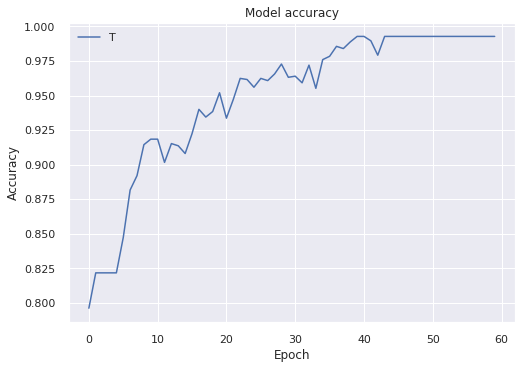

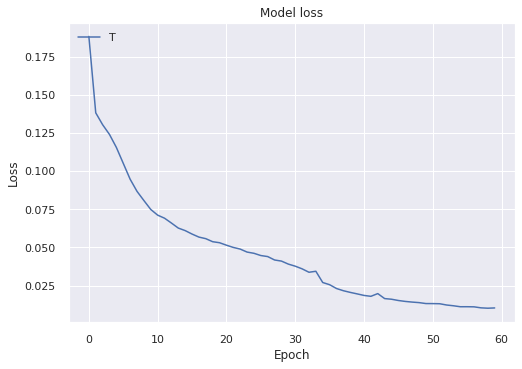

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

In [30]:
import pandas_profiling
pandas_profiling.ProfileReport(df)